In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import kendalltau
from scipy.stats import norm
from sklearn.linear_model import TheilSenRegressor
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.contingency_tables import mcnemar


In [3]:
df = pd.read_json('data/snowpits.json')
print(df)

       ID      date  time  snow_depth  wind precip   latitude  longitude  \
0      L1  20240227  1652         100     s   snow  78.190765  15.518860   
1    T4.1  20240227  1205          95     w   snow  78.255521  16.194478   
2      T5  20240229  1130         102    nw   snow  78.253592  16.175345   
3    L2.1  20240228  1025         122     e   None  78.210172  15.628620   
4    L2.2  20240228  1120         103     e   snow  78.210172  15.628623   
5    L2.3  20240228  1210         165     e   snow  78.210172  15.628620   
6    T4.2  20240301  1345          99    ne   snow  78.255275  16.193900   
7    T2.1  20240301  1300         115    ne   snow  78.256898  16.230525   
8      T1  20240301  1210          54    ne   snow  78.254785  16.249108   
9   TN1_1  20240302  1200         160  None   None  78.257897  16.142172   
10  TN1_2  20230302  1200         160  None   None  78.257897  16.142172   
11    TN2  20240302  1335         120  None   None  78.255537  16.115643   
12     B4  2

In [20]:
df_bin = df.copy()
df_failure = df[pd.to_numeric(df['ECT_x'], errors='coerce').notnull()]
df_no_failure = df[pd.to_numeric(df['ECT_x'], errors='coerce').isnull()]
df_no_failure = df_no_failure[pd.to_numeric(df_no_failure['PST_x'], errors='coerce').notnull()]

df_propagation = df_failure[pd.to_numeric(df_failure['ECT_y'], errors='coerce').notnull()]
df_no_propagation = df_failure[pd.to_numeric(df_failure['ECT_y'], errors='coerce').isnull()]


ECT_P = np.array(df_propagation["ECT_y"])
PST_P = np.array(df_propagation["PST_x"] / df_propagation["PST_y"])

ECT_NP = np.array(df_no_propagation["ECT_x"])
PST_NP = np.array(df_no_propagation["PST_x"] / df_no_propagation["PST_y"])

n = len(df_no_failure["ECT_y"])
ECT_NF = np.full(n, 31) 
PST_NF = np.array(df_no_failure["PST_x"] / df_no_failure["PST_y"])


ECT_propagation_depth = np.array(df_propagation["ECT_depth"])


The standardized statistic variable is: z =  1.19
The 5% critical value for a normal distribution is: z_alpha/2 =  1.96

Since, abs(z) < z_alpha/2, the independence hypothesis cannot be rejected!


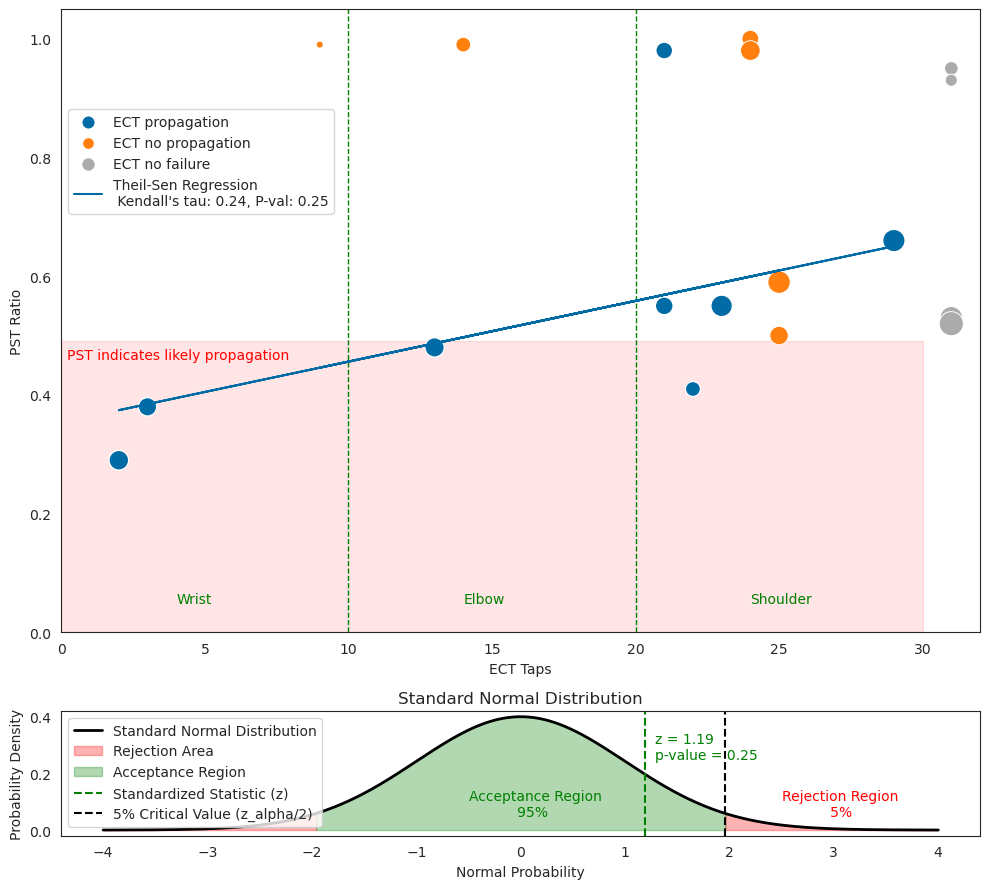

In [18]:

sns.set_style("white")

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 9), gridspec_kw={'height_ratios': [5, 1]})

plt.style.use('tableau-colorblind10')

# Add horizontal line at y=0.5 with text label
ax1.text(.2, 0.46, 'PST indicates likely propagation', color='red')

# Shade the area between y=0 and y=0.5 in red
ax1.fill_between(x=range(31), y1=0.49, y2=0, color='red', alpha=0.1)

# Add vertical lines at x=10 and x=20 with text labels
ax1.text(4, 0.05, 'Wrist', color='green')
ax1.axvline(x=10, color='green', linestyle='--', linewidth=1)
ax1.text(14, 0.05, 'Elbow', color='green')
ax1.axvline(x=20, color='green', linestyle='--', linewidth=1)
ax1.text(24, 0.05, 'Shoulder', color='green')

sns.scatterplot(x=ECT_P, y=PST_P, label="ECT propagation", s=(ECT_propagation_depth**1.4), ax=ax1)
sns.scatterplot(x=ECT_NP, y=PST_NP, label="ECT no propagation", s=(np.array(df_no_propagation["ECT_depth"])**1.4), ax=ax1)
sns.scatterplot(x=ECT_NF, y=PST_NF, label="ECT no failure", s=(np.array(df_no_failure["PST_depth"])**1.4), ax=ax1)

# Concatenate ECT_P and ECT_NP
ECT_all = np.concatenate((ECT_P, ECT_NP))

# Concatenate PST_P and PST_NP
PST_all = np.concatenate((PST_P, PST_NP))

# Perform Theil-Sen regression
model = TheilSenRegressor()
model.fit(ECT_all.reshape(-1, 1), PST_all)
predicted_values = model.predict(ECT_all.reshape(-1, 1))

# Calculate Kendall's tau and p-value
tau, p_value = kendalltau(ECT_all, PST_all)

# Plot Theil-Sen regression line
ax1.plot(ECT_all, predicted_values, label=f"Theil-Sen Regression \n Kendall's tau: {tau:.2f}, P-val: {p_value:.2f}")

# Set axis limits and labels for the first subplot
ax1.set_xlim(0, 32)
ax1.set_ylim(0, 1.05)
ax1.set_xlabel('ECT Taps')
ax1.set_ylabel('PST Ratio')
ax1.legend(loc=2, markerscale=.7, bbox_to_anchor=(0, .85))

# Second subplot for statistical analysis
amount = len(ECT_all)
z = tau / np.sqrt((2 * (2 * amount + 5)) / (9 * amount * (amount - 1)))

print('The standardized statistic variable is: z = ',z.round(2))

# Get 5% critical value for a standard normal distribution - since twotaild use 2.5%
z_alpha = norm.ppf(0.975)

print('The 5% critical value for a normal distribution is: z_alpha/2 = ', z_alpha.round(2))

if abs(z) < z_alpha:
    print('\nSince, abs(z) < z_alpha/2, the independence hypothesis cannot be rejected!')
    z_line_color = 'green'
else:
    print('\nSince, abs(z) > z_alpha/2, the independence hypothesis has to be rejected!')   
    print('\nThus, one can claim that ENSO influences winter precipitation in observed region at the 5% significance level.')
    z_line_color = 'red'

# Generate x values for the normal distribution plot
x = np.linspace(-4, 4, 1000)

# Calculate the y values for the normal distribution plot
y = norm.pdf(x, 0, 1)

# Plot the normal distribution curve
ax2.plot(x, y, 'k-', linewidth=2, label='Standard Normal Distribution')

# Shade the rejection and acceptance regions
x_fill_r = np.linspace(z_alpha, 4, 100)
y_fill_r = norm.pdf(x_fill_r, 0, 1)
ax2.fill_between(x_fill_r, y_fill_r, color='red', alpha=0.3, label='Rejection Area')

x_fill_l = np.linspace(-4,-z_alpha, 100)
y_fill_l = norm.pdf(x_fill_l, 0, 1)
ax2.fill_between(x_fill_l, y_fill_l, color='red', alpha=0.3)

x_fill_critical = np.linspace(-z_alpha, z_alpha, 100)
y_fill_critical = norm.pdf(x_fill_critical, 0, 1)
ax2.fill_between(x_fill_critical, y_fill_critical, color='green', alpha=0.3, label='Acceptance Region')

# Plot vertical lines for standardized statistic and critical value
ax2.axvline(x=z, color=z_line_color, linestyle='--', label='Standardized Statistic (z)')
ax2.axvline(x=z_alpha, color='k', linestyle='--', label='5% Critical Value (z_alpha/2)')

# Set labels and title for the second subplot
ax2.set_xlabel('Normal Probability')
ax2.set_ylabel('Probability Density')
ax2.set_title('Standard Normal Distribution')
ax2.annotate(f'z = {abs(z.round(2))}\np-value = {p_value.round(2)}', xy=(z + 0.1, 0.25), color='green')
ax2.annotate(f'Acceptance Region\n           95%', xy=(-0.5, 0.05), color='green')
ax2.annotate(f'Rejection Region\n           5%', xy=(2.5, 0.05), color='red')
ax2.legend(loc=2)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig("figures/subplot_ECT_vs_PST.pdf")
plt.show()

In [22]:
df_bin['ECT_bin'] = df_bin['ECT_y'].apply(lambda x: 1 if pd.notna(x) and not isinstance(x, str) else 0)
df_bin['PST_bin'] = df_bin.apply(lambda row: 1 if row['PST_x'] < 50 and row['PST_prop'] == 'end' else 0, axis=1)

df_bin = df_bin.head(19)
print(df_bin[['ECT_x','ECT_y','ECT_bin','PST_x','PST_prop','PST_bin']])

   ECT_x ECT_y  ECT_bin  PST_x PST_prop  PST_bin
0     25    np        0   50.0      arr        0
1     22    22        1   41.0      end        1
2     nf    nf        0    NaN     None        0
3      2     2        1   29.0      end        1
4     nf    nf        0   95.0      end        0
5      3     3        1   38.0      end        1
6     20    21        1   55.0      end        0
7     23    23        1   55.0      end        0
8     29    29        1   66.0      end        0
9     14    np        0   99.0      end        0
10    24    np        0  100.0     None        0
11    13    13        1   48.0      end        1
12    nf    nf        0   53.0      end        0
13     9    np        0   99.0      end        0
14    21    21        1   98.0      end        0
15    24    np        0   98.0      end        0
16    25    np        0   59.0      end        0
17    nf    nf        0   52.0      end        0
18    nf    nf        0   93.0      end        0


In [28]:

matching_results = [1 if ect == pst else 0 for ect, pst in zip(df_bin['ECT_bin'], df_bin['PST_bin'])]
agreement_percentage = (sum(matching_results) / len(matching_results)) * 100

print("Agreement Percentage:", agreement_percentage)



kappa = cohen_kappa_score(df_bin['ECT_bin'], df_bin['PST_bin'])

print("Cohen's Kappa Coefficient:", kappa)
# Calculate the number of observations
n = len(df_bin['ECT_bin'])

# Calculate the variance of the Cohen's Kappa coefficient
kappa_variance = (kappa * (1 - kappa)) / (n * (1 - ((n - 1) / (n * (n - 1)))))

# Calculate the standard error
kappa_standard_error = kappa_variance ** 0.5

# Calculate the z-score
z_score = kappa / kappa_standard_error

# Calculate the two-tailed p-value
p_value = stats.norm.sf(abs(z_score)) * 2

print("Cohen's Kappa Coefficient p-value:", p_value)



# Perform McNemar test
contingency_table = pd.crosstab(df_bin['ECT_bin'], df_bin['PST_bin'])
print(contingency_table)

result = mcnemar(contingency_table)
print("McNemar test statistic:", result.statistic)
print("McNemar test p-value:", result.pvalue)
print(df_bin[['ECT_bin','PST_bin']])

Agreement Percentage: 78.94736842105263
Cohen's Kappa Coefficient: 0.5365853658536586
Cohen's Kappa Coefficient p-value: 4.987437662507222e-06
PST_bin   0  1
ECT_bin       
0        11  0
1         4  4
McNemar test statistic: 0.0
McNemar test p-value: 0.125
    ECT_bin  PST_bin
0         0        0
1         1        1
2         0        0
3         1        1
4         0        0
5         1        1
6         1        0
7         1        0
8         1        0
9         0        0
10        0        0
11        1        1
12        0        0
13        0        0
14        1        0
15        0        0
16        0        0
17        0        0
18        0        0
